In [2]:
from fusemix.simulation import Simulation
from fusemix.imputation import MultipleImputer
from gower import gower_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import fusemix.clustering as clustering_utils

import warnings
import pickle
import importlib
import scikit_posthocs as sp
import pandas as pd
import numpy as np

from time import sleep 
from tqdm import tqdm_notebook

from scipy.stats import friedmanchisquare

importlib.reload(clustering_utils)

warnings.filterwarnings("ignore")

In [3]:
def read_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    

def write_pickle(var, path):
    with open(path, 'wb') as f:
       pickle.dump(var, f)

In [4]:
complete_data = read_pickle("test_data/loaded_data.pkl")


datasets = [15,17,33,45]

n_runs = 20

md_param_grid = {
    'props': [0.75,1.],
    'mf_proportions': [0.5,0.75],
    'mnar_proportions': [0.,0.25]
}

In [5]:
results_fusemix = read_pickle("output_simulation/fusemix.pickle")
results_singleimput= read_pickle("output_simulation/singleimput.pickle")
results_singleimput_knn= read_pickle("output_simulation/singleimput_knn.pickle")
results_kpod = read_pickle("output_simulation/kpod.pickle")


In [6]:
metrics = ['ari','ami','vm','cs','sh','ch','db']
internal_metrics = ['sh','ch','db']
external_metrics = ['ari','ami','vm','cs']
external_metrics_known = []

for em in external_metrics:
    external_metrics_known.append("known_"+em)


all_metrics = internal_metrics + external_metrics + external_metrics_known

#all_metrics = [m for m in all_metrics if not m in ['vm','known_vm']]

In [7]:
all_metrics

['sh',
 'ch',
 'db',
 'ari',
 'ami',
 'vm',
 'cs',
 'known_ari',
 'known_ami',
 'known_vm',
 'known_cs']

In [8]:
# For each dataset I want to count how many missing values I have as patterns have been generated stochastically 

# this is because I want to divide the simulations into low/high missing disregarding pyampute hyperparameters which may not reflect 
# the true amount of missing

missing_ratios = {}
missing_ratios_detailed = {}

for d in tqdm_notebook(datasets):
    missing_ratios[d] = []
    missing_ratios_detailed[d] = {}
    
    for prop in md_param_grid['props']:
        for mf_proportion in md_param_grid['mf_proportions']:
            for mnar_proportion in md_param_grid['mnar_proportions']:
                for seed in range(n_runs):
                    
                    directory = "test_data/"+str(d)+"/"+str(prop)+"_"+str(mf_proportion)+"_"+str(mnar_proportion)
                    simulated_data = read_pickle(directory+"/pipeline_"+str(seed)+".pickle")

                    missing_ratio = simulated_data.incomplete_data.isna().sum().sum() / simulated_data.incomplete_data.size
                    missing_ratios_detailed[d][(prop,mf_proportion,mnar_proportion,seed)] = missing_ratio
                    missing_ratios[d].append(missing_ratio)

  0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
len([v for v in missing_ratios_detailed[15].values() if v >= 0.])

160

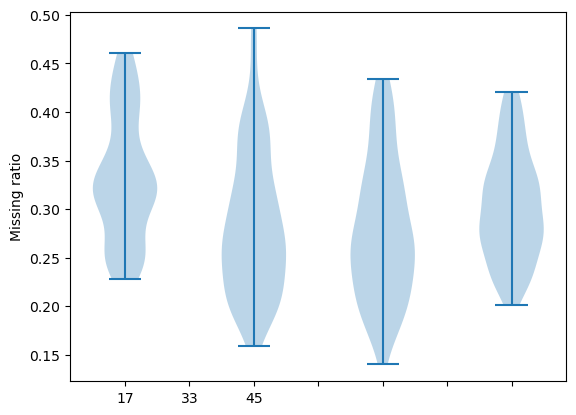

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

x1 = missing_ratios[15]
x2 = missing_ratios[17]
x3 = missing_ratios[33]
x4 = missing_ratios[45]

fig, ax = plt.subplots()
ax.set_ylabel('Missing ratio')

ax.violinplot([x1,x2,x3,x4]) 
ax.set_xticklabels(['15','17','33','45'])


plt.show()

In [11]:
# I want a dictionary for each method with [d][metrics] = list [] to aggregate results in mean +- std 

res_unstack_fusemix = {} 
res_unstack_singleimput = {} 
res_unstack_singleimput_knn = {} 
res_unstack_kpod = {} 

for d in datasets:
    res_unstack_fusemix[d] = {}
    res_unstack_singleimput[d] = {}
    res_unstack_singleimput_knn[d] = {} 
    res_unstack_kpod[d] = {}

    for m in all_metrics:
        res_unstack_fusemix[d][m] = []
        res_unstack_singleimput[d][m] = []
        res_unstack_singleimput_knn[d][m] = []
        res_unstack_kpod[d][m] = []
        

test_counts = {}


for d in tqdm_notebook(datasets, desc="Datasets"):
    test_counts[d] = 0
    for prop in md_param_grid['props']:
            for mf_proportion in md_param_grid['mf_proportions']:
                for mnar_proportion in md_param_grid['mnar_proportions']:
                    for seed in range(n_runs):
                        if missing_ratios_detailed[d][(prop,mf_proportion,mnar_proportion,seed)] >= 0.:
                            test_counts[d] += 1
                            for metric in all_metrics:
                                res_unstack_fusemix[d][metric].append(results_fusemix[d][(prop,mf_proportion,mnar_proportion)][metric][seed])
                                res_unstack_singleimput[d][metric].append(results_singleimput[d][(prop,mf_proportion,mnar_proportion)][metric][seed])
                                res_unstack_singleimput_knn[d][metric].append(results_singleimput_knn[d][(prop,mf_proportion,mnar_proportion)][metric][seed])
                                res_unstack_kpod[d][metric].append(results_kpod[d][(prop,mf_proportion,mnar_proportion)][metric][seed]) 

Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
sorted_items = sorted(missing_ratios_detailed[15].items(), key=lambda x: x[1])
keys = [k for k, v in sorted_items] # sorted values key (prop,mf.....,seed) for missing ratios
values = [v for k, v in sorted_items]  # sorted missing ratios                 

In [13]:
# to see performances with different missing ratios I want for each metric this dataframe 
#          Missing ratio 1 .......... Missing ratio N
# method1
# method2
# method3

# collect all rank tables
all_ranks = []

for d in datasets:
    for m in all_metrics:
        results_ordered = {
            'fusemix': [],
            'kpod': [],
            'singleimput': [],
            'singleimput_knn': []
        }

        for k in keys:
            k_ = (k[0], k[1], k[2])    
            results_ordered['fusemix'].append(results_fusemix[d][k_][m][k[3]])
            results_ordered['kpod'].append(results_kpod[d][k_][m][k[3]])
            results_ordered['singleimput'].append(results_singleimput[d][k_][m][k[3]])
            results_ordered['singleimput_knn'].append(results_singleimput_knn[d][k_][m][k[3]])

        df = pd.DataFrame(results_ordered).T
        df.columns = values  # missing ratios
        if m == 'db':
            ranks = df.rank(axis=0, ascending=True)
        else:
            ranks = df.rank(axis=0, ascending=False)
        ranks.columns = ranks.columns.astype(float)

        all_ranks.append(ranks)

# average across datasets + metrics
df_mean = pd.concat(all_ranks).groupby(level=0).mean()
df_std = pd.concat(all_ranks).groupby(level=0).std()


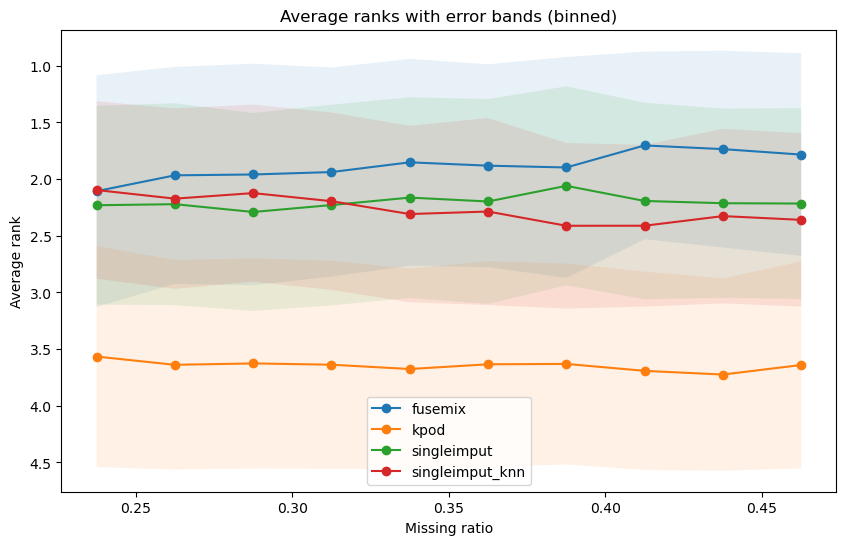

In [14]:


# bin edges (2.5% step)
bins = np.arange(0, df_mean.columns.max() + 0.025, 0.025)
col_to_bin = pd.cut(df_mean.columns, bins=bins, right=False)


df_binned = df_mean.groupby(col_to_bin, axis=1).mean()
df_binned = df_binned.dropna(axis=1, how="all")

df_std_binned = df_std.groupby(col_to_bin, axis=1).mean()
df_std_binned = df_std_binned.dropna(axis=1, how="all")


# Use bin midpoints for x-axis
x = [interval.mid for interval in df_binned.columns]

plt.figure(figsize=(10,6))
ax = plt.gca()

for method in df_binned.index:
    ax.plot(x, df_binned.loc[method], marker="o", label=method)
    ax.fill_between(
        x,
        df_binned.loc[method] - df_std_binned.loc[method],
        df_binned.loc[method] + df_std_binned.loc[method],
        alpha=0.1
    )

plt.xlabel("Missing ratio")
plt.ylabel("Average rank")
plt.title("Average ranks with error bands (binned)")
plt.legend()
plt.gca().invert_yaxis()  # rank 1 at top
plt.savefig("output_missing_ratio.png", dpi = 300)
plt.show()

In [15]:
fusemix_means = pd.DataFrame(res_unstack_fusemix).map(np.mean)
singleimput_means = pd.DataFrame(res_unstack_singleimput).map(np.mean)
singleimput_knn_means = pd.DataFrame(res_unstack_singleimput_knn).map(np.mean)
kpod_means = pd.DataFrame(res_unstack_kpod).map(np.mean)

fusemix_std = pd.DataFrame(res_unstack_fusemix).map(np.std)
singleimput_std = pd.DataFrame(res_unstack_singleimput).map(np.std)
singleimput_knn_std = pd.DataFrame(res_unstack_singleimput_knn).map(np.std)
kpod_std = pd.DataFrame(res_unstack_kpod).map(np.std)

In [27]:
pd.set_option('display.precision', 2)

merged = pd.concat([fusemix_means, singleimput_means, singleimput_knn_means,kpod_means], axis=1, keys=["fusemix", "singleimput_mice","singleimput_knn","kpod"])
merged.columns = merged.columns.swaplevel(0, 1)
merged = merged.sort_index(axis=1)

merged_std = pd.concat([fusemix_std, singleimput_std, singleimput_knn_std,kpod_std], axis=1, keys=["fusemix", "singleimput_mice","singleimput_knn","kpod"])
merged_std.columns = merged_std.columns.swaplevel(0, 1)
merged_std = merged_std.sort_index(axis=1)

assert merged.shape == merged_std.shape
assert (merged.columns == merged_std.columns).all()
assert (merged.index == merged_std.index).all()

merged_pretty = merged.round(3).astype(str) + " ± " + merged_std.round(3).astype(str)

merged_final = merged.copy()  # keep numeric
merged_final_pretty = merged_pretty  # display version


In [28]:
merged_final_pretty.loc[:,[15,17]].to_csv("output_pretty_15_17.csv")
merged_final_pretty.loc[:,[33,45]].to_csv("output_pretty_33_45.csv")

In [18]:
merged[17]

,fusemix,kpod,singleimput_knn,singleimput_mice
sh,0.400,0.342,0.394,0.402
ch,672.888,300.245,804.564,567.948
db,0.713,0.575,0.659,0.773
ari,0.898,0.120,0.811,0.951
ami,0.819,0.146,0.713,0.903
vm,0.819,0.148,0.714,0.903
cs,0.821,0.288,0.723,0.902
known_ari,0.781,0.094,0.730,0.719
known_ami,0.685,0.134,0.643,0.603
known_vm,0.685,0.136,0.643,0.604


In [19]:


def count_best_methods(df, special_min_metrics={"db"}):
    counts = {}

    for dataset in df.columns.levels[0]:
        subset = df[dataset]  # columns for this dataset (methods)
        for metric, row in subset.iterrows():
            if metric in special_min_metrics:
                # lower is better
                best_methods = row[row == row.min()].index
            else:
                # higher is better
                best_methods = row[row == row.max()].index
            for m in best_methods:
                counts[m] = counts.get(m, 0) + 1

    return pd.Series(counts).sort_values(ascending=False)




In [20]:
count_best_methods(merged.loc[:,:])


fusemix             23
singleimput_knn      8
singleimput_mice     8
kpod                 5
dtype: int64

1. Friedman test: compare multiple algorithms over different datasets

for each metric i test across dataset and NAs masks

In [21]:
fusemix_unfold = []
kpod_unfold = []
singleimput_unfold = []
singleimput_knn_unfold = []

for m in ['known_ami']:
    for d in datasets:
        if m == "db":
            fusemix_unfold += [1/x for x in res_unstack_fusemix[d][m]]
            kpod_unfold += [1/x for x in res_unstack_kpod[d][m]]
            singleimput_unfold += [1/x for x in res_unstack_singleimput[d][m]]
            singleimput_knn_unfold += [1/x for x in res_unstack_singleimput_knn[d][m]]
        else:
            fusemix_unfold += res_unstack_fusemix[d][m]
            kpod_unfold += res_unstack_kpod[d][m]
            singleimput_unfold += res_unstack_singleimput[d][m]
            singleimput_knn_unfold += res_unstack_singleimput_knn[d][m]

    stat, pval = friedmanchisquare(fusemix_unfold, kpod_unfold, singleimput_unfold, singleimput_knn_unfold)
    print(f"Metric: {m} pval: {pval}")

    data = np.column_stack((fusemix_unfold, kpod_unfold, singleimput_unfold,singleimput_knn_unfold))
    
    methods = ["fusemix","kpod","single","single_knn"]
    p_values = sp.posthoc_nemenyi_friedman(data)
    print(f"Post-hoc values with control: {p_values.values}")
    print(f"Best method: {methods[p_values.sum(axis = 1).argmin()]}")
    fusemix_unfold = []
    kpod_unfold = []
    singleimput_unfold = []
    singleimput_knn_unfold = []
    

    

Metric: known_ami pval: 0.0
Post-hoc values with control: [[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.00594038]
 [0.         0.         0.00594038 1.        ]]
Best method: fusemix


In [22]:
len(fusemix_unfold)

0

In [23]:
data = np.column_stack((fusemix_unfold, kpod_unfold, singleimput_unfold,singleimput_knn_unfold))

p_values = sp.posthoc_nemenyi_friedman(data)
print(p_values)

Empty DataFrame
Columns: []
Index: []


In [24]:
merged_swapped = merged.copy()
merged_swapped.columns = merged_swapped.columns.swaplevel(0, 1)

for m in all_metrics:

    fusemix_metrics = merged_swapped.loc[m,"fusemix"].values.flatten()
    singleimput_metrics = merged_swapped.loc[m,"singleimput"].values.flatten()
    kpod_metrics = merged_swapped.loc[m,"kpod"].values.flatten()
        
    print(f"Metric {m} pvalue :{friedmanchisquare(fusemix_metrics, singleimput_metrics, kpod_metrics).pvalue}")

KeyError: 'singleimput'

In [ ]:
len(res_unstack_fusemix[15]['sh'])

21